<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0110ENSkillsNetwork20647811-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


<h1>Linear Regression 1D: Training Two Parameter Mini-Batch Gradient Descent </h1> 


<h2>Objective</h2><ul><li> How to use PyTorch build-in functions to create a model.</li></ul> 


<h2>Table of Contents</h2>
<p>In this lab, you will create a model the PyTroch way, this will help you as models get more complicated</p>

<ul>
    <li><a href="https://#Makeup_Data">Make Some Data </a></li>
    <li><a href="https://#Model_Cost">Create the Model and Cost Function the PyTorch way </a></li>
    <li><a href="https://#BGD">Train the Model: Batch Gradient Descent</a></li>
</ul>

<p>Estimated Time Needed: <strong>30 min</strong></p>

<hr>


<h2>Preparation</h2>


We'll need the following libraries:


In [1]:
# These are the libraries we are going to use in the lab.

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

The class <code>plot_error_surfaces</code> is just to help you visualize the data space and the parameter space during training and has nothing to do with PyTorch.


In [2]:
# class for ploting  

class plot_error_surfaces(object):
    
    # Constructor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - w2 * self.x + b2) ** 2)
                count2 += 1
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize = (7.5, 5))
            plt.axes(projection = '3d').plot_surface(self.w, self.b, self.Z, rstride = 1, cstride = 1, cmap = 'viridis', edgecolor = 'none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
    # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.LOSS.append(loss)
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
    
    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection = '3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c = 'r', marker = 'x', s = 200, alpha = 1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot diagram    
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim()
        plt.plot(self.x, self.y, 'ro', label = "training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label = "estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-10, 15))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.title('Loss Surface Contour Iteration' + str(self.n) )
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

<!--Empty Space for separating topics-->


<h2 id="Makeup_Data">Make Some Data</h2>


Import libraries and set random seed.


In [3]:
# Import libraries and set random seed

import torch
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(1)

Generate values from -3 to 3 that create a line with a slope of 1 and a bias of -1. This is the line that you need to estimate. Add some noise to the data:


In [4]:
# Create Data Class

class Data(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = torch.arange(-3, 3, 0.1).view(-1, 1)
        self.f = 1 * self.x - 1
        self.y = self.f + 0.1 * torch.randn(self.x.size())
        self.len = self.x.shape[0]
        
    # Getter
    def __getitem__(self,index):    
        return self.x[index],self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

Create a dataset object:


In [5]:
# Create dataset object

dataset = Data()

Plot out the data and the line.


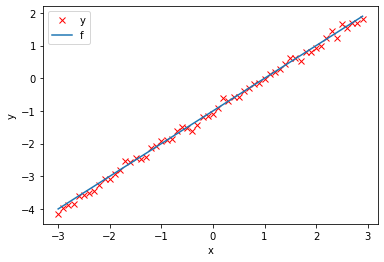

In [6]:
# Plot the data

plt.plot(dataset.x.numpy(), dataset.y.numpy(), 'rx', label = 'y')
plt.plot(dataset.x.numpy(), dataset.f.numpy(), label = 'f')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

<!--Empty Space for separating topics-->


<h2 id="Model_Cost">Create the Model and Total Loss Function (Cost)</h2>


Create a linear regression class


In [7]:
# Create a linear regression model class

from torch import nn, optim

class linear_regression(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

We will use PyTorch build-in functions to create a criterion function; this calculates the total loss or cost


In [8]:
# Build in cost function

criterion = nn.MSELoss()

Create a linear regression object and optimizer object, the optimizer object will use the linear regression object.


In [9]:
# Create optimizer

model = linear_regression(1,1)
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [10]:
list(model.parameters())

[Parameter containing:
 tensor([[0.3636]], requires_grad=True), Parameter containing:
 tensor([0.4957], requires_grad=True)]

Remember to construct an optimizer you have to give it an iterable containing the parameters i.e. provide <code> model.parameters()</code> as an input to the object constructor


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter2/2.4model_optmiz.png" width="100" alt="Model Optimizer" />


Similar to the model, the optimizer has a state dictionary:


In [11]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.01,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'params': [0, 1]}]}

Many of the keys correspond to more advanced optimizers.


Create a <code>Dataloader</code> object:


In [12]:
# Create Dataloader object

trainloader = DataLoader(dataset = dataset, batch_size = 1)

PyTorch randomly initialises your model parameters. If we use those parameters, the result will not be very insightful as convergence will be extremely fast. So we will initialise the parameters such that they will take longer to converge, i.e. look cool


In [13]:
# Customize the weight and bias

model.state_dict()['linear.weight'][0] = -15
model.state_dict()['linear.bias'][0] = -10

Create a plotting object, not part of PyTroch, just used to help visualize


In [14]:
# Create plot surface object

get_surface = plot_error_surfaces(15, 13, dataset.x, dataset.y, 30, go = False)

<!--Empty Space for separating topics-->


<h2 id="BGD">Train the Model via Batch Gradient Descent</h2>


Run 10 epochs of stochastic gradient descent: <b>bug</b> data space is 1 iteration ahead of parameter space.


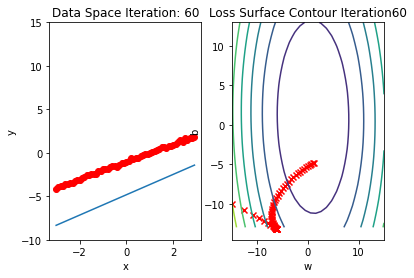

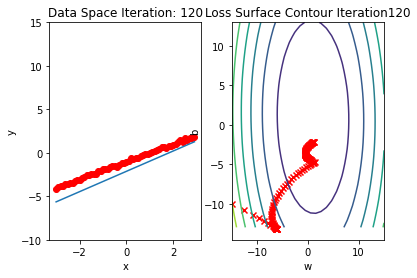

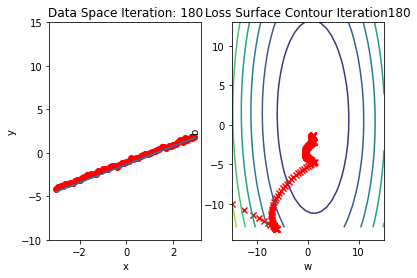

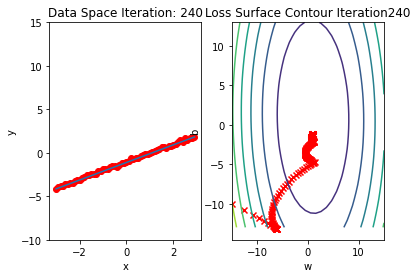

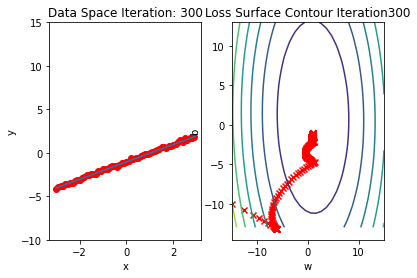

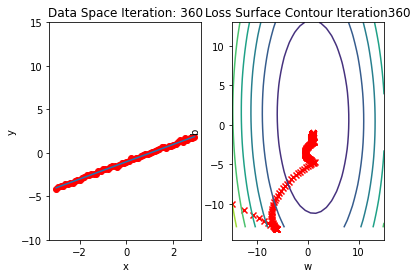

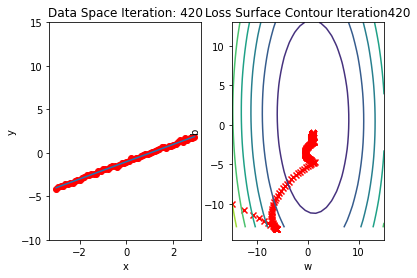

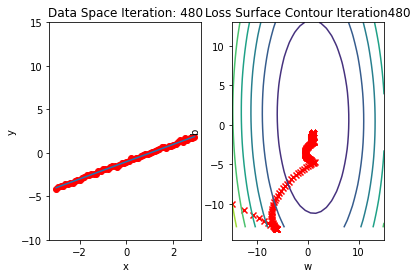

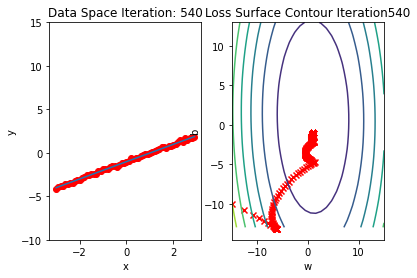

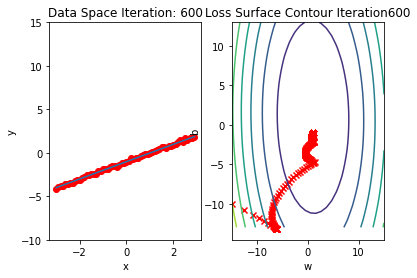

In [15]:
# Train Model

def train_model_BGD(iter):
    for epoch in range(iter):
        for x,y in trainloader:
            yhat = model(x)
            loss = criterion(yhat, y)
            get_surface.set_para_loss(model, loss.tolist())          
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
        get_surface.plot_ps()


train_model_BGD(10)

In [16]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[0.9932]])),
             ('linear.bias', tensor([-1.0174]))])

Let's use the following diagram to help clarify the process. The model takes <code>x</code> to produce an estimate <code>yhat</code>, it will then be compared to the actual <code>y</code>  with the loss function.


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter2/2.4get_loss.png" width="400" alt="Old Model Cost diagram" />


When we call <code>backward()</code> on the loss function, it will handle the differentiation. Calling the method step on the optimizer object it will update the parameters as they were inputs when we constructed the optimizer object. The connection is shown in the following figure :


<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter2/2.4update_param.png" width="500" alt="Model Cost with optimizer" />


<!--Empty Space for separating topics-->


<h3>Practice</h3>


Try to train the model via BGD with <code>lr = 0.1</code>. Use <code>optimizer</code> and the following given variables.


In [17]:
# Practice: Train the model via BGD using optimizer

model = linear_regression(1,1)
model.state_dict()['linear.weight'][0] = -15
model.state_dict()['linear.bias'][0] = -10
get_surface = plot_error_surfaces(15, 13, dataset.x, dataset.y, 30, go = False)

In [18]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
trainloader = DataLoader(dataset = dataset, batch_size=1)

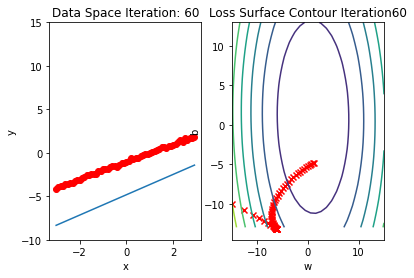

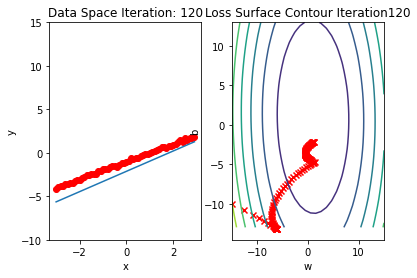

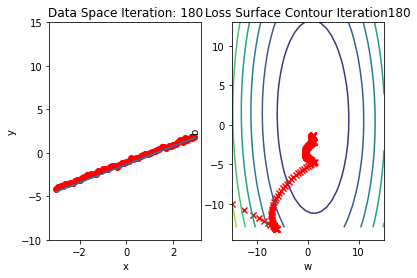

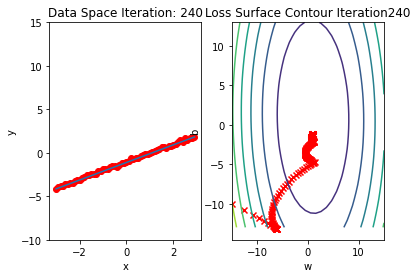

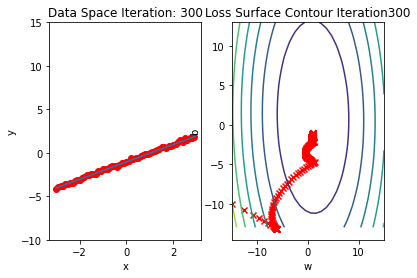

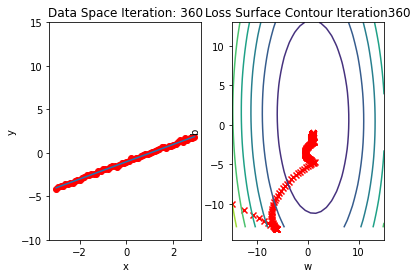

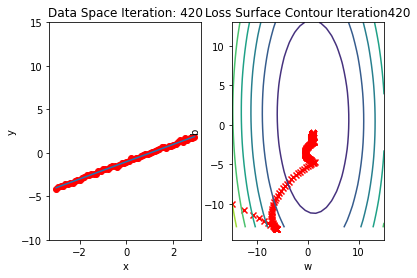

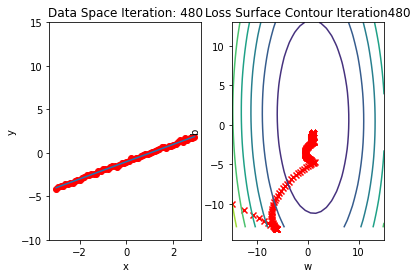

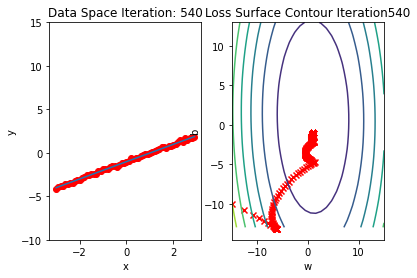

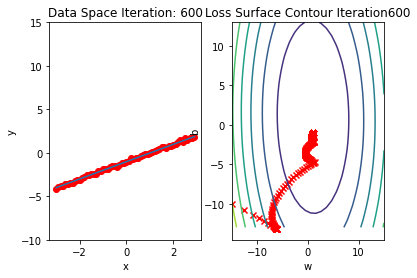

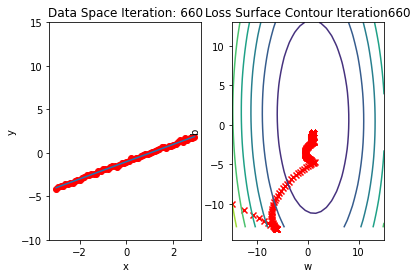

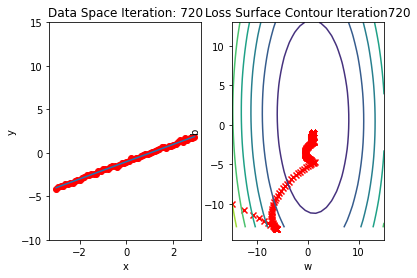

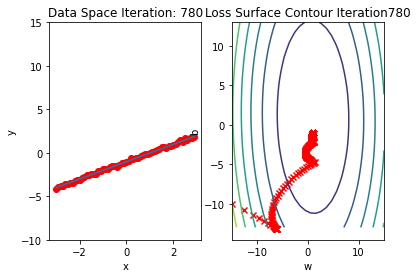

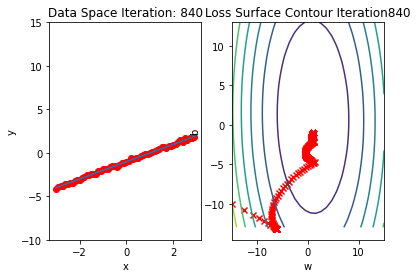

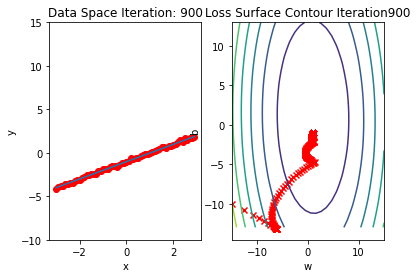

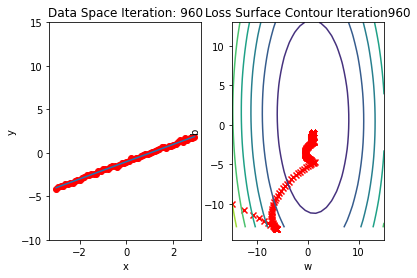

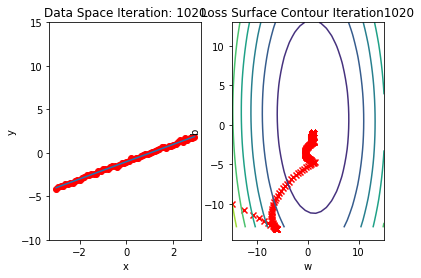

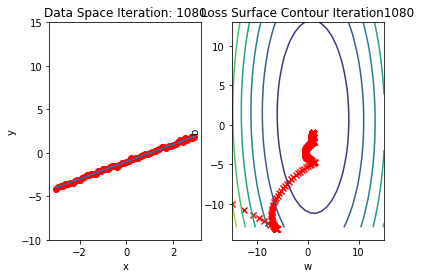

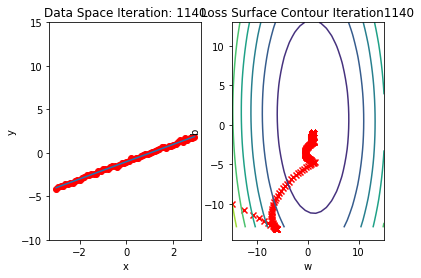

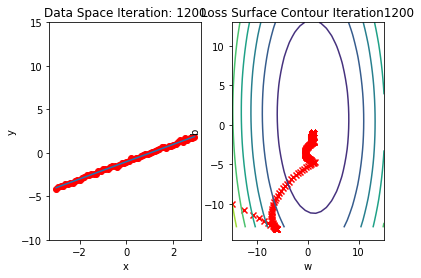

In [20]:
def my_train(epochs):
  for _ in range(epochs):
    for x,y in trainloader:
      yhat = model(x)
      loss = criterion(y, yhat)
      get_surface.set_para_loss(model, loss.tolist()) 
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    get_surface.plot_ps()

my_train(20)

*Double*-click <b>here</b> for the solution.

<!-- 
optimizer = optim.SGD(model.parameters(), lr = 0.1)
trainloader = DataLoader(dataset = dataset, batch_size = 1)

def my_train_model(iter):
    for epoch in range(iter):
        for x,y in trainloader:
            yhat = model(x)
            loss = criterion(yhat, y)
            get_surface.set_para_loss(model, loss.tolist()) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        get_surface.plot_ps()

train_model_BGD(10)
-->


<a href="https://dataplatform.cloud.ibm.com/registration/stepone?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0110ENSkillsNetwork20647811-2022-01-01&context=cpdaas&apps=data_science_experience%2Cwatson_machine_learning"><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/Watson_Studio.png"/></a>


<!--Empty Space for separating topics-->


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0110ENSkillsNetwork20647811-2022-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0110ENSkillsNetwork20647811-2022-01-01">Michelle Carey</a>, <a href="https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0110ENSkillsNetwork20647811-2022-01-01">Mavis Zhou</a>


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description                                          |
| ----------------- | ------- | ---------- | ----------------------------------------------------------- |
| 2020-09-23        | 2.0     | Shubham    | Migrated Lab to Markdown and added to course repo in GitLab |


<hr>


## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
